# An introduction to scientific computing 

This notebook will guide you through some basic concepts in scientific computing using python, with a focus on computational mathematics.

Don't Panic! We won't dive too deep into the math staff, though unavoidable there would be some definitions and derivations. We try to include only the minimal theory that is necessary.

After reading this tutorial, you should be able to grasp a sense of how python can help people compute in a scientific and efficient way(and why it saves many mathematicians' time). Though you might be familiar with some functions or modules used in this tutorial, it's still good to know how they can be combined to solve mathematical problems.

In [1]:
%matplotlib inline

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy as sc
import scipy.sparse as sparse
import scipy.sparse.linalg
from operator import sub
from scipy.sparse import identity

## 1. Approximating second order derivative

Suppose we want the find the second order derivative of a function $u(x)$. This seems trivial to students who major in mathematics(or even those who have taken a series of courses in calculus). However, the functions that we deal with in class are oftentime simplified, such as $u(x)$ = $sin(x)$ or $u(x)$ = $\frac{1}{x + 1}$ (in a more advanced calculus course you might see things like $u(x) = \frac{cos(x)e^{x+1}}{x}$). However things are more complicated in the real world, and it's pretty common that the functions you are looking for are too complex to differentiate. In some extreme cases, they might not be differentiable at some points(and even well-defined!). 

To tackle this problem, people come up with the idea of mathematical approximation, in which we approximate the derivative of a function through numerical computations instead of mathematical derivation, while bounding the error with a reasonable threshold. The key idea here is to sacrifice the exactness a bit for computational efficiency.

For example, the second order derivative of a function at a given point can be approximated by a linear combination of values of this function evaluated at the vicinities of this point(think of taylor expansion!):

$$u''(x) \approx c_0u(x - h) + c_1u(x - \frac{h}{2}) + c_2u(x) + c_3u(x + h) + c_4u(x + 2h)$$

The coefficients c's to achieve a lowest error bound can be determined by solving the following linear system(For more reference please see https://en.wikipedia.org/wiki/Finite_difference_method):

$$
\begin{pmatrix}
  1 & 1 & 1 & 1 & 1 \\
  -1 & -\frac{1}{2} & 0 & 1 & 2 \\
  \frac{1}{2} & \frac{1}{8} & 0 & \frac{1}{2} & 2  \\
  -\frac{1}{6} & -\frac{1}{48} & 0 & \frac{1}{6} & \frac{4}{3} \\
  \frac{1}{24} & \frac{1}{384} & 0 & \frac{1}{24} & \frac{2}{3}
\end{pmatrix} 
C = 
\begin{pmatrix}
  0 \\
  0 \\
  \frac{1}{h^2} \\
  0 \\
  0
\end{pmatrix} 
$$

where 
$$
C = \begin{pmatrix}
  c_0 \\
  c_1 \\
  c_2 \\
  c_3 \\
  c_4
\end{pmatrix} 
$$

Now, let's compute this in python, try different values of $h$, and make a plot to see how the error is bounded by different $h$

First we define a function getC which takes the step size $h$ as a single parameter and output the coefficients of c's, as derived above.

In [3]:
def getC(h):
    """
    Argument: h, the step size
    Return: coefficients of c's
    """
    # solve for c_j
    A = np.array([[1, 1, 1, 1, 1], [-1, -1.0 / 2, 0, 1, 2], [1.0 / 2, 1.0 / 8, 0, 1.0 / 2, 2], \
                [-1.0 / 6, -1.0 / 48, 0, 1.0 / 6, 4.0 / 3], [1.0 / 24, 1.0 / 384, 0, 1.0 / 24, 2.0 / 3]])
    b = np.array([0, 0, 1.0 / pow(h, 2), 0, 0])
    c = np.linalg.solve(A, b)
    return c

Second, define function $u(x)$ and its analytical second order derivative(This is used to justify our method, and is often unavailable in real life problems)

In [4]:
# define u and u''
u = lambda x: math.sin(2 * x) # u(x)
uD2 = lambda x: - 4 * math.sin(2 * x) # u''(x)

Then, we can define a function to the error of approximation:

In [5]:
def getApproxError(x0, h):
    """
    Argument: 
        x0: the value on the x-axis
        h: the step size
    Return: error(difference between approximation and true value) given specific step size h
    """
    x = [x0 - h, x0 - h / 2, x0, x0 + h, x0 + 2 * h] # vicinities of x0
    ux = list(map(u, x)) # u(x) evaluated at the vicinities
    trueval = uD2(x0) # analytical solution at x0
    c = getC(h) # get coefficients of c's give h
    approxval = sum([ux[i] * c[i] for i in range(0, len(c))]) # approximation of u''(x0)
    return approxval - trueval

Now we can compute the errors of approximation of $u''(x)$, given different step size h, and make a plot to see how the errors are bounded by different step sizes.

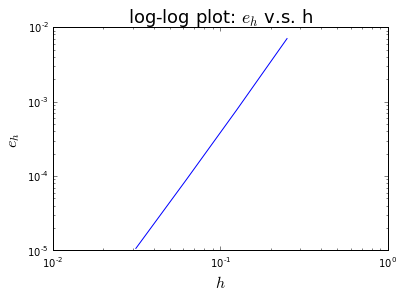

In [6]:
h = [pow(2, x) for x in [-2, -3, -4, -5]]
e_h = [getApproxError(1, i) for i in h]

## plot
plt.loglog(h, e_h);
plt.xlabel(r'$h$', fontsize = 16);
plt.ylabel(r'$e_h$', fontsize = 16);
plt.title(r'log-log plot: $e_h$ v.s. h', fontsize = 18, color = 'black');

As we can see the error is lower if the step size of h is small. This is justifiable since smaller step sizes are more likely to get closer approximations.

## 2. Heat equation

In this section we introduce 1D heat equation and solve it by forward-time central-space(FTCS) scheme. Basically the idea is to discretize the interval into n grid points, calculate the initial values of $u(x, 0)$, and then iterate overtime.

The 1D heat equation can be formulated as:

$$
  \begin{cases}
    u_t = u_{xx} \text{ , } x \in (0, 1) \text{ , } t > 0\\
    u(x, 0)  = u_0(x) \text{ , }\\
    u(0, t) = g_0(t) \text{ , } u(1, t) = g_1(t)
  \end{cases}
$$

where u(x, t) is a function taking two parameters: the first as a spatial parameter(in this case can be regarded as the value on the x-axis) and the second the time parameter. For simplicity we restrict x to between 0 and 1, and the boundary conditions are given as $u_0(x)$, $g_0(t)$ and $g_1(t)$.

The forward-time central-space(FTCS) can be written as:

$$
u^{n + 1} = (I + kA)u^n + kg^n
$$

where $u^n = (u_1^n, \dots, u_{m-1}^n)^T$ and $g^n = g(t_n)$, and

$$
A = \frac{1}{h^2}
\begin{pmatrix}
  -2 & 1\\
  1 & -2 & 1 \\
    & \ddots & \ddots & \ddots  \\
    &   &  1 & -2 & 1 \\
    &   &  & 1 & -2
\end{pmatrix} 
$$

$$
g(t) = \frac{1}{h^2}
\begin{pmatrix}
  g_0(t) \\
  0 \\
  \dots \\
  0 \\
  g_1(t)
\end{pmatrix} 
$$

Note that the $g_i(t)$ is in a sparse form.

The idea is straight forward: iterate over timestep, for every iteration update the current value of $u(x)$, if the timestep and number of grid points are set properly, after iterations the $u(x)$ should be a good approximation of the analytical solution.

To simplify the system, we set $g_0(t) = g_1(t) = 0$ and $u_0(x) = 0.5\sin(5 \pi x) + \sin( \pi x))$. Note that under this simplification there's no need the compute $g(t)$, since all its entries are 0.

Again, computations can be formulated into matrix operations, as define below.

In [7]:
def myFun(n0, t0, timestep):
    """
    Argument: 
        n0: number of grids
        t0: end time
        timestep, number of iteration
    Return: 
        x: data points on the x-axis
        u: numerical solution
        gx: analytical solution
        maxe: max-nomr error
        h: step size
    """
    n = n0
    t = t0
    g = lambda x: 1.0/ 2 * math.exp(-36 * pow(math.pi, 2) * t) * math.sin(6.0 * math.pi * x) + \
        math.exp(-pow(math.pi, 2) * t) * math.sin(math.pi * x) # analytical form
    x = np.linspace(0, 1, n + 1) # grid points on the x-axis
    gx = list(map(g, x)) # analytical solutions
    k = 0.0001 # step rate, too large --> won't converge; too small --> slow and need more iterations
    x = x[1 : -1] # u(0) = u(1) = 0: no need for calculations 
    h = 1.0 / n
    
    # get A
    n0 = len(x) # number of grid points we need to calculate 
    data = np.ones((3, n0))
    data[0] *= 1.0
    data[2] *= 1.0
    data[1] *= -2.0
    diags = [-1.0, 0, 1.0]
    A = sparse.spdiags(data, diags, n0, n0) / pow(h, 2)
    
    # loop for timestep
    u = list(map(lambda y: 0.5 * math.sin(6 * math.pi * y) + math.sin(math.pi * y), x)) # u_0
    for ts in range(1, timestep):
        u = (identity(n0, dtype='int8', format='dia') + k * A) * u 
    u = [0] + list(u) + [0] # add u(0) and u(1), which are 0
    
    # calculate error
    e = list(map(sub, u, gx))
    maxe = max(map(abs, e))
    gx = gx[1:-1]
    
    # return x, numerical soln, real soln, infinity norm error, h
    return x, u, gx, maxe, h

To see how well the numerical solution approximate the analytical solution, we can make the following plot.

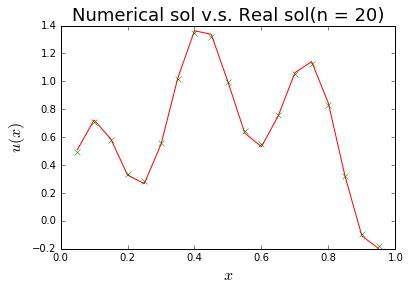

In [8]:
## plot numerical & real soln
x, u, gx, e, h = myFun(20, 0.0005, 5) # n0, t0, timestep
u = u[1:-1]
plt.plot(x, u, 'r'); # numerical soln
plt.plot(x, gx, 'gx'); # real soln
plt.title("Numerical sol v.s. Real sol(n = 20)", fontsize = 18, color = 'black'); 
plt.xlabel(r"$x$", fontsize = 16);
plt.ylabel(r"$u(x)$", fontsize = 16);

We see that the numerical solution catches the analytical solution pretty well. However the function seems weird. The reason is that the number of grid points is relatively small, and thus the approximated function seems to be uncontinuous. To get a smoother approximation, we can simply raise the number of n, as shown below.

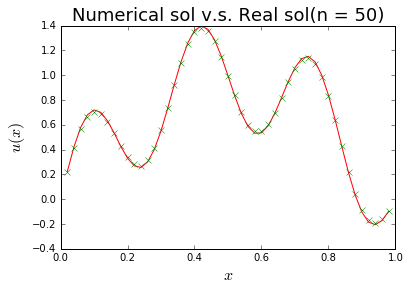

In [9]:
## plot numerical & real soln for larger n
x, u, gx, e, h = myFun(50, 0.0005, 5) # n0, t0, timestep
u = u[1:-1]
plt.plot(x, u, 'r'); # numerical soln
plt.plot(x, gx, 'gx'); # real soln
plt.title("Numerical sol v.s. Real sol(n = 50)", fontsize = 18, color = 'black'); 
plt.xlabel(r"$x$", fontsize = 16);
plt.ylabel(r"$u(x)$", fontsize = 16);

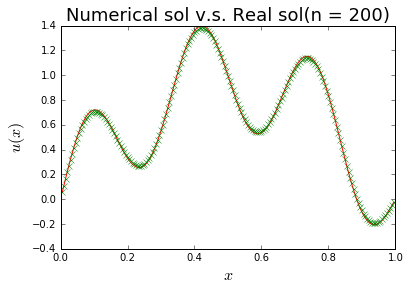

In [10]:
## plot numerical & real soln for even larger n
x, u, gx, e, h = myFun(200, 0.0005, 5) # n0, t0, timestep
u = u[1:-1]
plt.plot(x, u, 'r'); # numerical soln
plt.plot(x, gx, 'gx'); # real soln
plt.title("Numerical sol v.s. Real sol(n = 200)", fontsize = 18, color = 'black'); 
plt.xlabel(r"$x$", fontsize = 16);
plt.ylabel(r"$u(x)$", fontsize = 16);

However, if the number of grid points is too large, things might go wrong! For example, if use set n = 5000, the numerical solution will be distorted because of round-off error(and other issues).

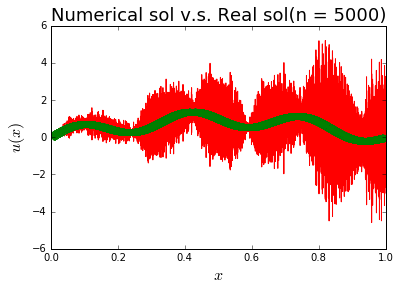

In [11]:
## plot numerical & real soln
x, u, gx, e, h = myFun(5000, 0.0005, 5) # n0, t0, timestep
u = u[1:-1]
plt.plot(x, u, 'r'); # numerical soln
plt.plot(x, gx, 'gx'); # real soln
plt.title("Numerical sol v.s. Real sol(n = 5000)", fontsize = 18, color = 'black'); 
plt.xlabel(r"$x$", fontsize = 16);
plt.ylabel(r"$u(x)$", fontsize = 16);

Similar to the result we draw from section one, when n is in a proper range, larger n will produce better approximation because smaller step size result in more precise estimation.

In [12]:
n = [10, 20, 50, 80, 100]
e_n = []
h_n = []
for k in n:
    _, _, _, tmpe, tmph = myFun(k, 0.0005, 5)
    e_n.append(tmpe)
    h_n.append(tmph)

le_n = [math.log(x) for x in e_n]
lh = [math.log(x) for x in h_n]
ln = [math.log(x) for x in n]

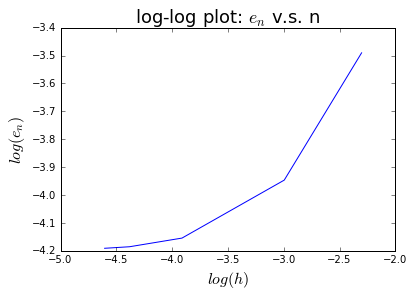

In [13]:
## plot log(e_n) v.s. log(n), where e_n is the max-norm error
plt.plot(lh, le_n)
plt.xlabel(r'$log(h)$', fontsize = 16);
plt.ylabel(r'$log(e_n)$', fontsize = 16);
plt.title(r'log-log plot: $e_n$ v.s. n', fontsize = 18, color = 'black');

## 3. Euler-Bernoulli equation

The Euler-Bernoulli equation describes the deformation $u$ of a beam subject to a transversal force
with intensity $q$(For more reference please see https://en.wikipedia.org/wiki/Euler%E2%80%93Bernoulli_beam_theory), which can be described as follow(restrict the beam to [0, 1] with two ends fixed):

$$
  \begin{cases}
    \frac{d^4u}{dx^4} = f(x) \text{   , } x \in (0, 1)\\
    u(0) = u'(0) = u(1) = u'(1) = 0 \\
  \end{cases}
$$

where f(x) is known and we want to approximate the function $u$ in the interval (0, 1), given the above conditions.

This kind of system is categorized as elliptic equations and can be solved by finite difference(For more reference please see https://ocw.mit.edu/courses/aeronautics-and-astronautics/16-920j-numerical-methods-for-partial-differential-equations-sma-5212-spring-2003/lecture-notes/lecs2and3_notes.pdf). Mathematically we can do that through matrix computation too.

Skipping mathematical derivation, the approximation of $u$ can be determined by solving the following linear system:

$$
\begin{pmatrix}
  7 & -4 & 1 & \dots & 0 & 0 & 0 \\
  -4 & 6 & -4 & \dots & 0 & 0 & 0 \\
  1 & -4 & 6 & \dots & 0 & 0 & 0 \\
  \dots \\
  0 & 0 & 0 & \dots & 6 & -4 & -1 \\
  0 & 0 & 0 & \dots & -4 & 6 & -4 \\
  0 & 0 & 0 & \dots & 1 & -4 & 7
\end{pmatrix} 
u = 
\begin{pmatrix}
  f_1 \\
  f_2 \\
  \dots \\
  f_{n-2} \\
  f_{n-1}
\end{pmatrix} 
$$

where 
$$
u = \begin{pmatrix}
  u_1 \\
  u_2 \\
  \dots \\
  u_{n-2} \\
  u_{n-1}
\end{pmatrix} 
$$

Here $f_i$ denotes the $i_{th}$ equally spaced n + 1 mesh grid on the given interval, in this case (0, 1). For example if n is 2 then the interval is divided into three points, namely 0, 0.5 and 1. Note that here we omit the first and the last grids since $u(0) = u_0 = 0$ and $u(1) = u_n = 0$

Now we can start our computation. First define the function f(x) and the analytical solution g(x), as well as the interval and number of grid points. Again remember that in the real world we will never have the analytical solution.

In [14]:
## define functions, set parameters
f = lambda x: math.exp(x) * (pow(x, 4) + 14 * pow(x, 3) + 49 * pow(x, 2) + 32 * x - 12)
g = lambda x: math.exp(x) * pow(x, 2) * pow(1 - x, 2)
interval = [0, 1]
n = pow(2, 10)

Next, define the function getXandF which returns the x values and corresponding f(x), given the number of grid points.

In [15]:
## define function
def getXandF(f, interval, n):
    """
    Arguments:
        f: f(x)
        interval: interval of x, such as [0, 1]
        n: number of equally spaced grids
    Return:
        x: points on the x-axis, equally spaced
        fx: f(x) evaluated on x
    """
    x = np.linspace(interval[0], interval[1], n + 1) # generate equally spaced n + 1 grid points
    fx = list(map(f, x))
    return x, fx

Then the function getUandF, which computes the analytical solution and numerical approximation, and return the errors for error analysis. Note that the numerical approximations are computed as described above.

In [16]:
def getUandF(f, g, interval, n):
    """
    Arguments:
        f: f(x)
        g: g(x) analytical solution
        interval: interval of x, such as [0, 1]
        n: number of equally spaced grids
    Return:
        u: numerical approximations of u(x) on the interval
        gx: analytical solution of u(x) on the interval
        e: error vector
        maxe: maximum of the absolute error
    """
    x = np.linspace(interval[0], interval[1], n + 1) # generate equally spaced n + 1 grid points
    gx = list(map(g, x)) # analytical solutions
    
    x = x[1 : -1] # u(0) = u(1) = 0: no need for calculations
    h = 1.0 / n # step size
    
    # matrix A
    n0 = len(x) # number of grid points we need to calculate
    data = np.ones((5, n0))
    data[1] *= -4
    data[3] *= -4
    data[2] *= 6
    data[2][0] = 7
    data[2][n0 - 1] = 7
    diags = [-2, -1, 0, 1, 2]
    A = sparse.spdiags(data, diags, n0, n0) / pow(h, 4)
    
    # calculate u, the numerical approximation, by solving the linear system
    fx = list(map(f, x))
    u = list(sparse.linalg.spsolve(sparse.csr_matrix(A), fx))
    u = [0] + u + [0] # add u(0) and u(1), which are 0
    
    # calculate error and maximum error
    e = list(map(sub, u, gx))
    maxe = max(map(abs, e))
    
    return u, gx, e, maxe

Now we are ready to compute the numerical and analytical solution, and the errors.

In [17]:
## calculate x and f(x), u(x)
x, fx = getXandF(f, interval, n)
ux, _, _, _ = getUandF(f, g, interval, n)

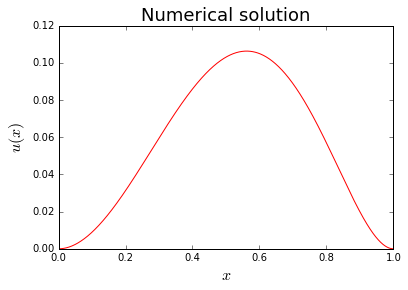

In [18]:
## plot
plt.plot(x, ux, 'r'); # semi-colon
plt.title("Numerical solution", fontsize = 18, color = 'black');
plt.xlabel(r"$x$", fontsize = 16);
plt.ylabel(r"$u(x)$", fontsize = 16);

To see how well our numerical solution approximate the true solution with different step sizes, we can plot the max-norm error versus n, as described bellow.

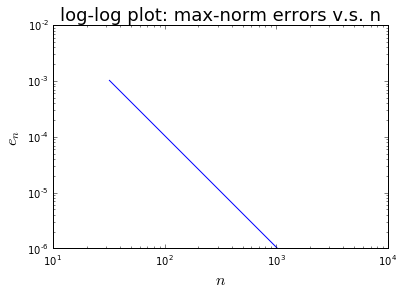

In [19]:
## set parameters
n = [pow(2, p) for p in [5, 6, 7, 8, 9, 10]]

## calculate max error
maxe = []
for i in n:
    _, _, _, tmpe = getUandF(f, g, interval, i)
    maxe.append(tmpe)

## plot
plt.loglog(n, maxe);
plt.xlabel(r'$n$', fontsize = 16);
plt.ylabel(r'$e_n$', fontsize = 16);
plt.title('log-log plot: max-norm errors v.s. n', fontsize = 18, color = 'black');

As it turns out, the more the grid points(In other words, the less step size), the less the error. This is consistent with what we found in the first section: smaller step size leads to more accurate approximation.